# VEME Workshop 2024 - Single cell transcriptomics

## Practice 1 - Quality Control, Integration, Dimensionality Reduction, and Clustering

## Introduction

In this Practical, we will be analyzing data that was sourced from Melms *et al.*'s 2021 Nature publication: *A molecular single-cell lung atlas of lethal COVID-19*. In this study, single nucleus RNA sequencing was conducted using samples acquired from the lungs of individuals post-mortem. There were 26 samples, 19 of which were from individuals who died as a result of COVID-19 infection and 7 individuals who served as the control group. The annotated data (anndata/adata) that is featured in this Jupyter notebook is a subsample of the original atlas. The original data underwent doublet removal using scVI's SOLO model and then 5-fold reduced (each sample was reduced).'

This notebook is split contains Practice 1, and Practice 2 is kept in another Jupyter notebook (VEME_scRNA_Prac2.ipynb). Practice 1 consists of steps of the pipeline such as Quality Control, Batch Integration, Dimensionality Reduction and Clustering. Practice 2 contains steps such as Gene Marker Discovery, Cluster Annotation, and other downstream analyses tasks.  

#### 1.1 Preparing our environment

In [1]:
# importing necessary libraries
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#reading in annotated data object
adata = sc.read_h5ad('data_1/GSE171524_downsample.h5ad')

#### 1.2 Preprocessing and QC

In [3]:
# taking a look at the adata object before QC - we will be doing this alot as many changes will be made to this object throughout this course
adata

AnnData object with n_obs × n_vars = 58152 × 34546
    obs: 'group', 'donor', 'treatment', 'batch'

In [4]:
# annotating mitochondrial genes
adata.var['mt'] = adata.var.index.str.startswith('MT-')

In [5]:
#reference list of known ribosomal genes
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)

In [6]:
#we use that reference list to annotate ribosomal genes
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)

In [7]:
# calculating Quality Control Metrics
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt', 'ribo'], percent_top = None, log1p = False, inplace = True)

In [8]:
# notice the added objects in 'adata.obs' and 'adata.var' 
adata

AnnData object with n_obs × n_vars = 58152 × 34546
    obs: 'group', 'donor', 'treatment', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [9]:
# filtering out any genes that don't appear in at least 3 cells 
sc.pp.filter_genes(adata, min_cells = 3)

In [10]:
# notice the reduction in n_vars
adata

AnnData object with n_obs × n_vars = 58152 × 31332
    obs: 'group', 'donor', 'treatment', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

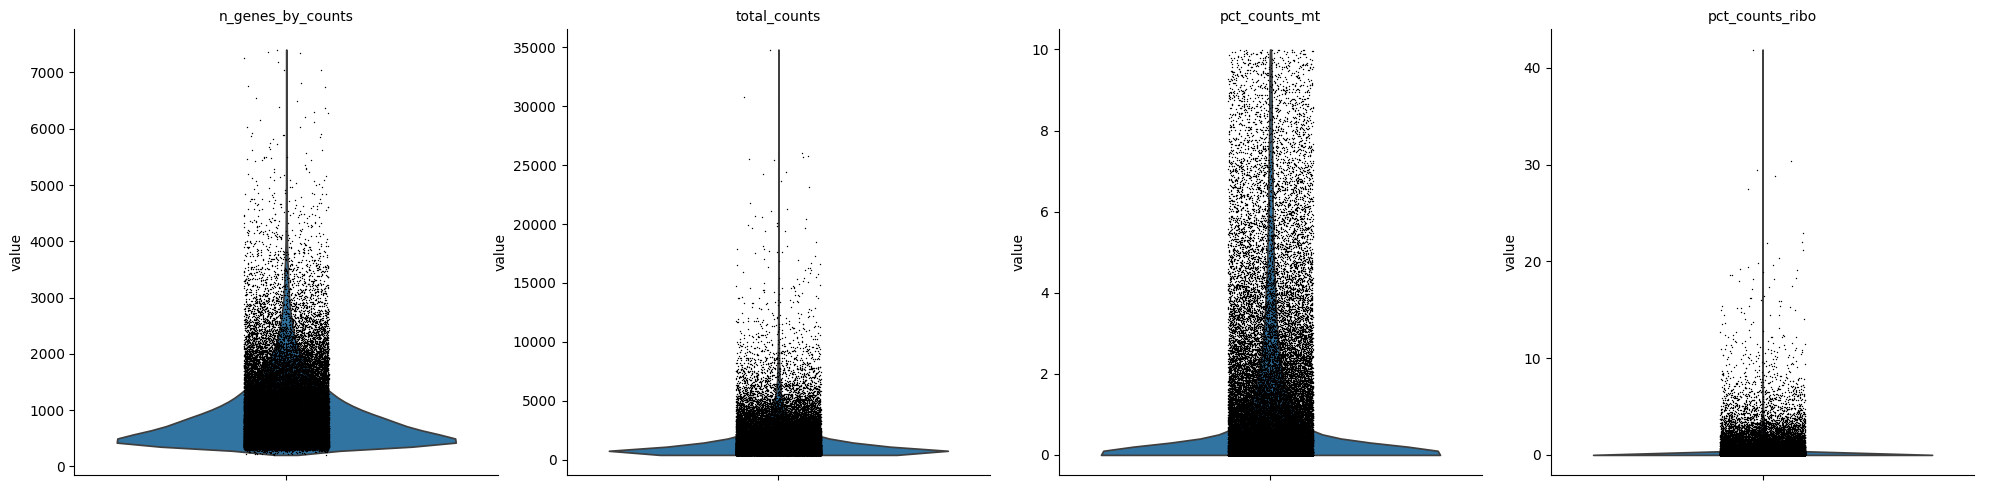

In [11]:
# plotting some QC metrics to get acquainted to the data and to determine filtering steps
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], multi_panel=True)

Each of these plots represent the distribution of covariates that are used to conduct QC. The x-axis contains one variable (listed above each plot). The y-axes differ for each of these plots. For `n_genes_by_counts`, the y values indicate the number of genes per UMI counts in each cell - outliers can indicate remaining multiplets that passed through doublet detection or other artefacts. For `total_counts`, the y values indicate the total number of UMI counts in each cell - outliers can be interpreted similarly to `n_genes_by_counts`. As for `pct_counts_mt`, the y values indicate the percentage of RNA reads in that cell that are mitochondrial genes - this is important to consider, as outliers may indicate non-viable/dying cells. For `pct_counts_ribo`, the y values are similar to `pct_counts_mt`'s y values, except we are looking at the percentage of reads that are from ribosomal genes - this can also be interpreted similarly to `pct_counts_mt`.

##### 1.2.1 Filtering based on percentage of ribosomal reads

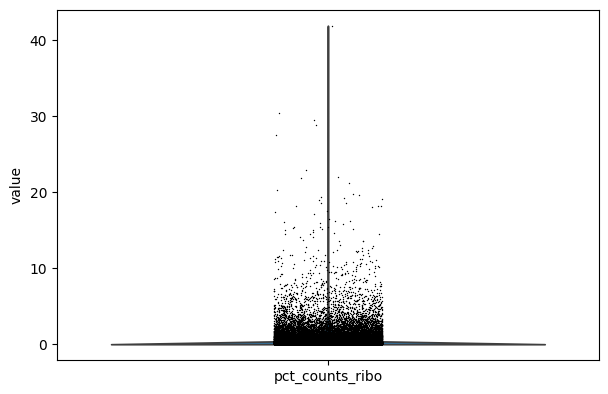

In [12]:
# plotting the distribution of cells' proportion of ribosomal reads
sc.pl.violin(adata, 'pct_counts_ribo')

As mentioned before, the y axis details the percentage of RNA reads that are ribosomal genes. When looking at the distribution, you can tell that most cells have a ribosomal read percentage under ~5%. Let's plot a histogram to give us a bit more insight into this distribution.

In the histogram produced below, the x-axis corresponds to the percentage of ribosomal reads and the y-axis displays the count of cells that possess that percentage of ribosomal genes. 

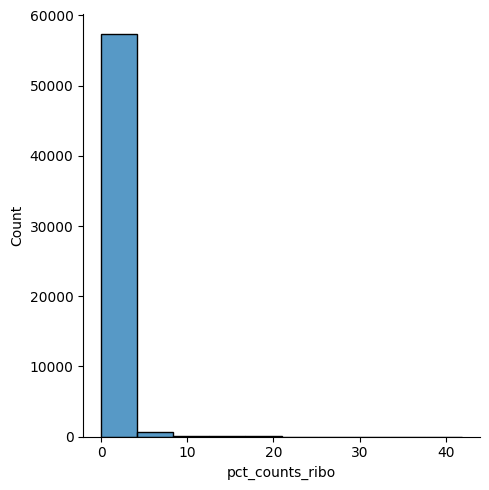

In [13]:
sns.displot(adata.obs, x = 'pct_counts_ribo', bins = 10)

As seen in the plots above, most cells certainly have a proportion of ribosomal reads less than 5%. We will filter out cells with a proportion of ribosomal reads that are greater than 3%, as these outliers as may correspond to low quality cells for analysis.

In [14]:
#decided upon thresholding value after looking at `pct_counts_ribo` distribution 
upper_lim_ribo = 3

In [15]:
# filtering the adata object
adata = adata[adata.obs.pct_counts_ribo < upper_lim_ribo]

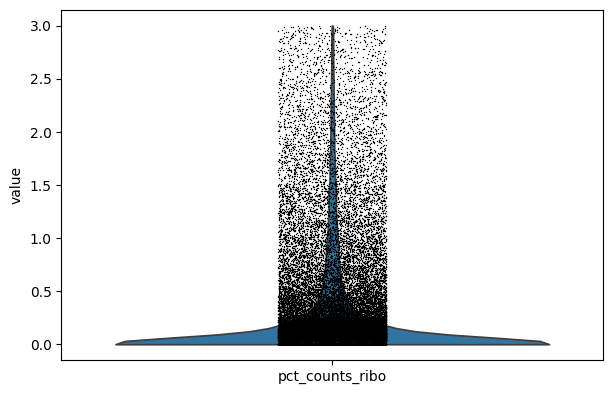

In [16]:
# plotting distribution after filtering
sc.pl.violin(adata, 'pct_counts_ribo')

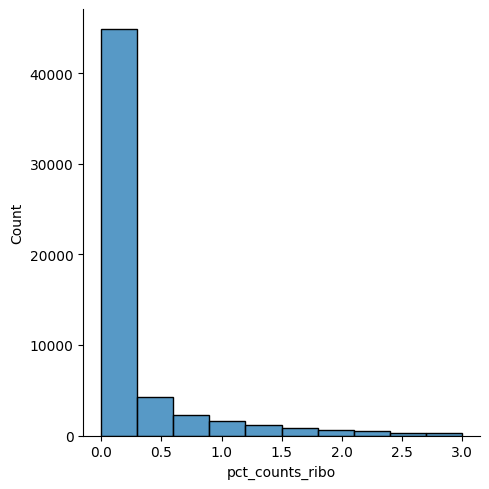

In [17]:
sns.displot(adata.obs, x = 'pct_counts_ribo', bins = 10)

As we can see in the violin plot and histogram, the maximum `pct_counts_ribo` is now 3% due to our filtering. 

In [18]:
# take note of the number of cells - decrease from our initial 58152 cells
adata

View of AnnData object with n_obs × n_vars = 56677 × 31332
    obs: 'group', 'donor', 'treatment', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

##### 1.2.2 Filtering based on number of genes per UMI counts

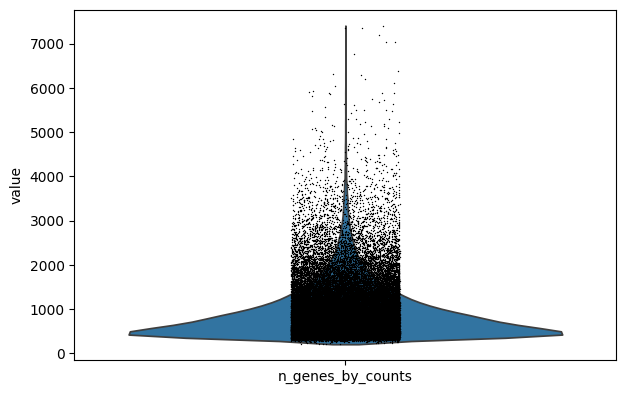

In [19]:
# observing distribution before filtering
sc.pl.violin(adata,'n_genes_by_counts')

The x-axis contains the sole variable `n_genes_by_counts` and the y-axis displays the values of number of genes per UMI counts in each cell.

In [20]:
upper_n_genes = np.quantile(adata.obs.n_genes_by_counts.values, .98)
upper_n_genes
# this is the value to be used to filter out cells that have a greater `n_genes_by_counts` 

2737.0

In [21]:
# filtering the adata object based on determined threshold
adata = adata[adata.obs.n_genes_by_counts < upper_n_genes]

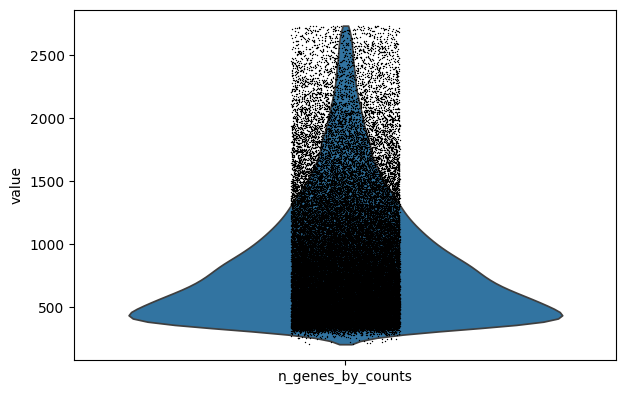

In [22]:
# observing distribution after filtering
sc.pl.violin(adata,'n_genes_by_counts')

In [23]:
# now look at how many cells we have now
adata

View of AnnData object with n_obs × n_vars = 55542 × 31332
    obs: 'group', 'donor', 'treatment', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

##### 1.2.3 Filtering based on proportion of mitochondrial reads

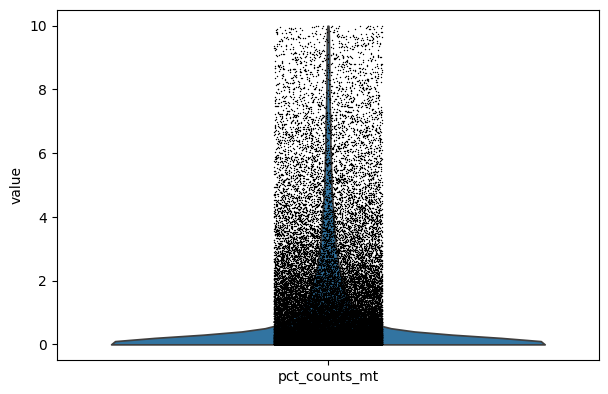

In [24]:
# observing distribution prior to filtering
sc.pl.violin(adata, 'pct_counts_mt')

This axes for this plot are essentially the same as the one seen in our `pct_counts_ribo` filtering step, except the x-axis contains the `pct_counts_mt` variable. 

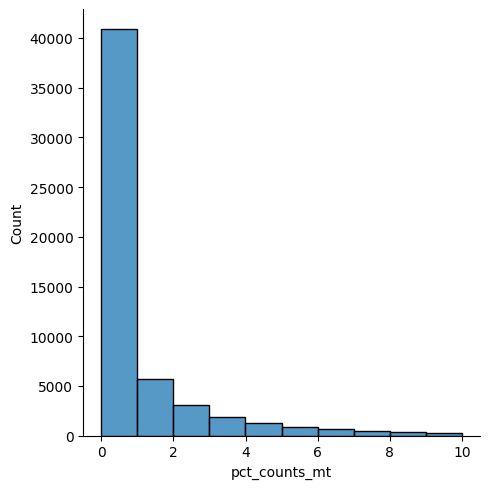

In [25]:
# let's investigate this distibution a bit more with a histogram
sns.displot(adata.obs, x = 'pct_counts_mt', bins = 10)

As you can see in the plots above, most cells have a mitochondrial read percentage around 0 - 4%. As a safe bet, we will filter out cells with a greater mitochondrial percentage than 3%.

In [26]:
adata = adata[adata.obs.pct_counts_mt < 3]

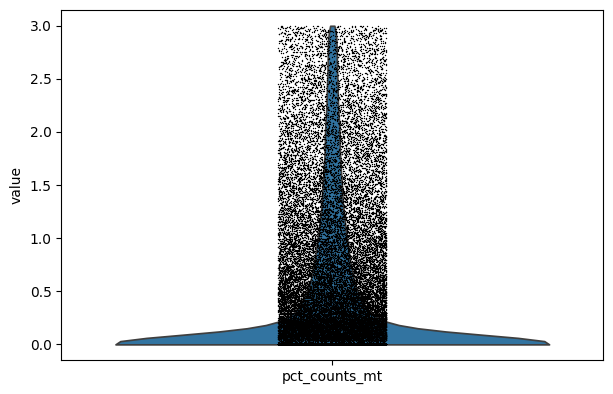

In [27]:
# plotting the distribution after filtering 
sc.pl.violin(adata, 'pct_counts_mt')

In [28]:
# now look at how many cells we have now!
adata

View of AnnData object with n_obs × n_vars = 49656 × 31332
    obs: 'group', 'donor', 'treatment', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [29]:
# adata.write('data_1/GSE171524_post_qc.h5ad')

##### 1.2.4 End of QC
As we can see in the last instance of the anndata object, we have cut down the size of the object to a considerable degree. Approximately 14% of our cells were filtered out (8496 cells). The cells filtered out most likely reflected artefacts such as undetected doublets, empty droplets, dying cells etc. 

#### 1.3 Batch Integration and Dimensionality Reduction

In [30]:
# adata = sc.read_h5ad('data_1/GSE171524_post_qc.h5ad')

In [29]:
adata

View of AnnData object with n_obs × n_vars = 49656 × 31332
    obs: 'group', 'donor', 'treatment', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

##### 1.3.1 Observing the data before integration

In [30]:
sc.pp.pca(adata, n_comps = 30)

c:\Users\pintardde\AppData\Local\anaconda3\envs\VEME_scRNA\lib\site-packages\scanpy\preprocessing\_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


In [31]:
sc.pp.neighbors(adata) #note: takes ~3 mins to run

In [32]:
sc.tl.umap(adata, n_components = 30)

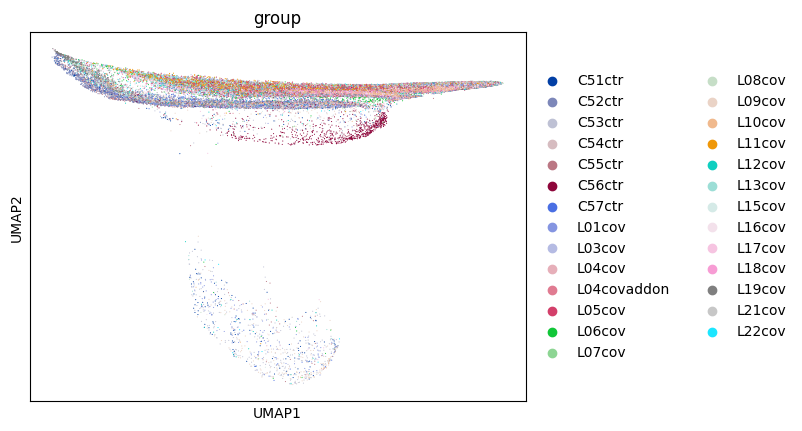

In [33]:
sc.pl.umap(adata, color = ['group'])

In the 2-D UMAP embedding of the data, the cells are colored by the sample they originated from. This is a display of "batch effects". Seemingly, cells from the same samples cluster together since their transcriptomic reads were produced under identical conditions. There is also very few distinct clusters present. This can cause issues in downstream tasks, notably, it can confound the results we aquire from clustering. So we will use a deep learning tool called `scVI` to integrate the different samples in the data to mitigate batch effects. Keep the plot above in mind when we get to plotting in section 1.4.

##### 1.3.2 Preparing the adata object for integration

In [34]:
# importing the library to be used
import scvi 

In [35]:
# copying raw counts to a separate layer since `pp_normalize_total()` and `pp.log1p()` will work on the default (raw) matrix
adata.layers['counts'] = adata.X.copy()

In [36]:
# see the new location of the raw cell x gene matrix (i.e. layers: 'counts')
adata

AnnData object with n_obs × n_vars = 49656 × 31332
    obs: 'group', 'donor', 'treatment', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'pca', 'neighbors', 'umap', 'group_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

Many functions in scanpy will act on the raw count data, and many of these functions may have a preference for normalized/log-transformed data. Considering this, we will create a new layer called `counts` to store our raw cell x gene matrix and then we normalized and transformed the data and saved it in the `raw` slot so that it can be preferentially used in other functions. The `counts` layer will be used for scVI batch integration.

In [37]:
# extra filtering step to help scVI work
sc.pp.filter_genes(adata, min_cells = 100)

In [38]:
#normalizing the expression across all cells
sc.pp.normalize_total(adata, target_sum = 1e4)

In [39]:
# log(x + 1) transformation of the data
sc.pp.log1p(adata)

In [40]:
# saving the normalized-log transformed data into raw slot to be used in downstream tasks
adata.raw = adata

When using scVI, it is generally best to have your number of cells be much larger than the number of genes, so we are going to include only the top 5,000 highly variable genes using `pp.highly_variable`. This is a sort of preliminary dimension reduction.

In [41]:
sc.pp.highly_variable_genes(adata, n_top_genes = 5000, subset = True, layer = 'counts', flavor = 'seurat_v3', batch_key = 'group')

In [42]:
# notice that there are now only 5000 genes left - these are the top 5000 highly variable genes 
adata

AnnData object with n_obs × n_vars = 49656 × 5000
    obs: 'group', 'donor', 'treatment', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'pca', 'neighbors', 'umap', 'group_colors', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

##### 1.3.3 Setting up and training the scVI model

Training the model can take quite a long time. We can load in a pretrained model used for this same dataset to get the latent representation we need for clustering.

In [45]:
# take note of the 'counts' layer being used for training the scVI model
#scvi.model.SCVI.setup_anndata(adata, layer = 'counts', categorical_covariate_keys = ['group'], continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])

In [46]:
# the last time I ran this cell of code, it took about 82 minutes to complete!
# model = scvi.model.SCVI(adata)
# model.train()

##### 1.3.4 Loading in pretrained model

In [43]:
model = scvi.model.SCVI.load('../model/')

INFO     File ../model/model.pt already downloaded                                                                 


c:\Users\pintardde\AppData\Local\anaconda3\envs\VEME_scRNA\lib\site-packages\scvi\model\base\_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(m

In [44]:
adata.obsm['X_scVI'] = model.get_latent_representation()

In [45]:
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size=1e4)

In [46]:
# take notice of the added 'X_scVI' array in 'obsm', as well as the added 'scvi_normalized' matrix in 'layers'
adata

AnnData object with n_obs × n_vars = 49656 × 5000
    obs: 'group', 'donor', 'treatment', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'pca', 'neighbors', 'umap', 'group_colors', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

In [51]:
# model.save('model', save_anndata=True)

In [52]:
#adata.write('data/GSE171524_integrated.h5ad')

#### 1.4 Clustering

##### 1.4.1 Restoring dimensionality for features

Before we head into further steps for clustering, we are going to quickly restore the dimensionality of the genes in our adata object for the purposes of downstream tasks such as gene marker discovery for cell type clusters. We are going to read in a new adata object (`adata2`), specifically the adata object we obtained after Quality Control. All we are doing is just transferring the `X_scVI` latent space to this adata object that contains the full set of genes after QC filtering. 

In [47]:
adata

AnnData object with n_obs × n_vars = 49656 × 5000
    obs: 'group', 'donor', 'treatment', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'pca', 'neighbors', 'umap', 'group_colors', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

In [48]:
adata2 = sc.read('data_1\GSE171524_post_qc.h5ad')

In [49]:
# transferring the scVI latent space over to new adata2 object
adata2.obsm['X_scVI'] = adata.obsm['X_scVI']

In [50]:
# take notice of the added 'X_scVI' in obsm
adata2

AnnData object with n_obs × n_vars = 49656 × 31332
    obs: 'group', 'donor', 'treatment', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    obsm: 'X_scVI'

In [51]:
# overwriting adata with adata2 for further analysis. all other layers and annotations lost in the object are not necessary for future steps
adata = adata2

In [52]:
# new adata object
adata

AnnData object with n_obs × n_vars = 49656 × 31332
    obs: 'group', 'donor', 'treatment', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    obsm: 'X_scVI'

##### 1.4.2 Dimensionality Reduction for clustering and visualization

The dimensions of this data were compressed when running scVI (i.e. the latent space that is returned). However, dimensionality reduction is not only useful for clustering, it is also extremely useful in displaying the data. 

In [53]:
# running PCA again on this new dimensional space
sc.tl.pca(adata, n_comps = 30)

In [54]:
#Creating neighborhood and connectivity matrices which are used for clustering. The scVI latent space is being used to compute this neighborhood graph
sc.pp.neighbors(adata, use_rep='X_scVI', random_state=42)

In [55]:
# notice the added 'X_pca' in obsm, as well as the added arrays in obsp: 'distances' and 'connectivities' are results of the pp.neighbors function
adata

AnnData object with n_obs × n_vars = 49656 × 31332
    obs: 'group', 'donor', 'treatment', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'pca', 'neighbors'
    obsm: 'X_scVI', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [57]:
# running UMAP to obtain embedding for visualization 
sc.tl.umap(adata, random_state=42)

In [58]:
#Running Leiden algorithm for clustering
sc.tl.leiden(adata, resolution = 0.45, key_added = 'leiden_intermediate', seed=42)

C:\Users\pintardde\AppData\Local\Temp\2\ipykernel_23176\704122135.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.45, key_added = 'leiden_intermediate', seed=42)


In [59]:
# take notice of the added 'leiden_intermediate' column; this indicates the cluster membership of each cell based on leiden clustering at 0.45 resolution
adata.obs

,group,donor,treatment,batch,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,leiden_intermediate
GACTGATAGCATACTC-1_13-12-0,L06cov,L06cov,COVID-19,0,1844,3136.0,38.0,1.211735,9.0,0.286990,0
TCGGATAGTCCAGAAG-1_13-12-0,L06cov,L06cov,COVID-19,0,1874,3475.0,4.0,0.115108,50.0,1.438849,6
AGGTGTTGTGCCTTCT-1_13-12-0,L06cov,L06cov,COVID-19,0,1758,2927.0,0.0,0.000000,48.0,1.639904,5
TCAGCAATCATCTACT-1_13-12-0,L06cov,L06cov,COVID-19,0,622,798.0,5.0,0.626566,16.0,2.005013,12
GTGGCGTGTTAGTTCG-1_13-12-0,L06cov,L06cov,COVID-19,0,571,710.0,6.0,0.845070,9.0,1.267606,2
...,...,...,...,...,...,...,...,...,...,...,...
CAACCTCGTTCAGCTA-1_17-16-26,L10cov,L10cov,COVID-19,26,1180,1868.0,0.0,0.000000,2.0,0.107066,4
CATACAGCATACTGTG-1_17-16-26,L10cov,L10cov,COVID-19,26,1460,2209.0,0.0,0.000000,0.0,0.000000,7
TCATGGAAGCTACTAC-1_17-16-26,L10cov,L10cov,COVID-19,26,420,517.0,2.0,0.386847,0.0,0.000000,0
TCGCAGGCAACCAACT-1_17-16-26,L10cov,L10cov,COVID-19,26,1270,2096.0,0.0,0.000000,1.0,0.047710,1


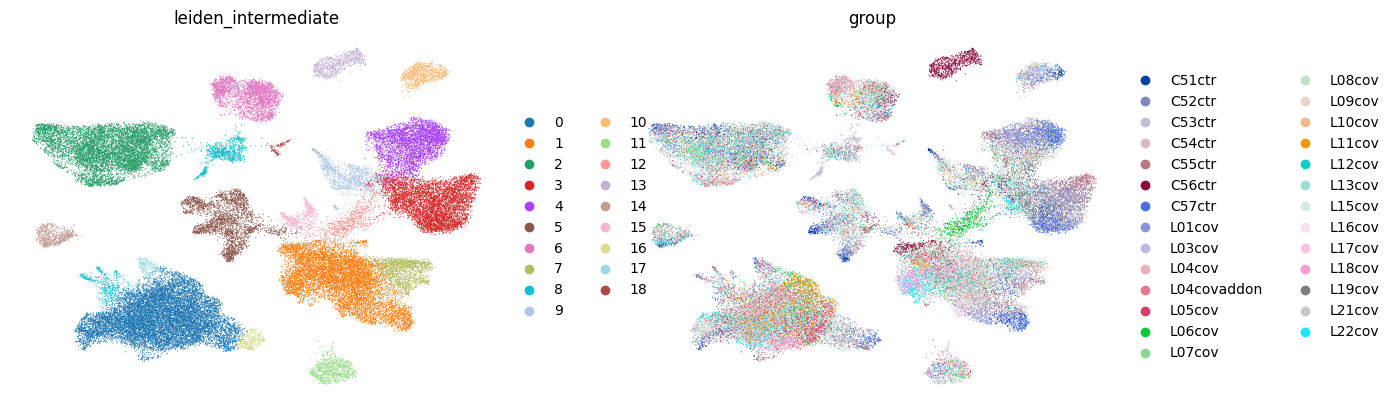

In [60]:
sc.pl.umap(adata, color = ['leiden_intermediate', 'group'], frameon = False)

In the plots above, the left one shows the cluster membership of the cells in UMAP space. The right plot shows the sample that each cell comes from. When compared to the original UMAP created before running scVI, you can see the vast difference in the distribution of cells from individual samples. We can see an "intermixing" of cells from different samples within each discrete cluster. This serves as a good indicator that the data was well integrated. Interestingly, we can see that there is a lone cluster in the upper right region (could be located in a different area for other's UMAPs) that is only composed of cells from sample 'C56ctr'; perhaps the cells from this sample contained a higher proportion of a particular cell type when compared to other samples; maybe these cells reflect a particular state seen in individuals who are not infected by lethal COVID-19. 

##### 1.4.2 Playing with clustering parameters

The process of clustering and annotating clusters can be considered somewhat of an art - there currently is no gold-standard in terms of approaches to clustering and annotation. Here, we will be tweaking the `resolution` parameter in the leiden algorithm. Put simply, resolution determines the number of clusters that are formed. The resolution value ranges from 0 - 1, with values closer to 0 resulting in lesser clusters forming and values closer to 1 resulting in more, granular clusters.

In the paper that this dataset was sourced from, the authors provided 3 different levels of annotation: 1) `cell_type_main` (9 cell type clusters), 2) `cell_type_intermediate` (19 cell type clusters), and 3) `cell_type_fine` (41 cell type clusters). Previously, we obtained the `cell_type_intermediate` level of clustering by seeting `resolution` to 0.5. In this section of the exercise, we are going to tweak the leiden algorithm to try our best at replicating the two other levels of cluster granularity.

##### Replicating `cell_type_main` cluster level
 

In [61]:
sc.tl.leiden(adata, resolution = 0.03, key_added='leiden_main', seed=42)

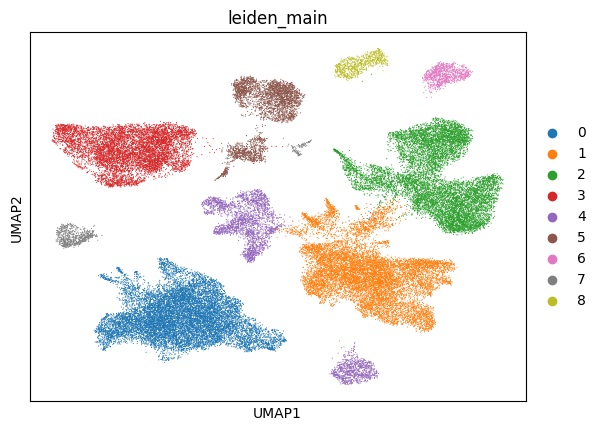

In [62]:
sc.pl.umap(adata, color = ['leiden_main'])

Just like in `cell_type_main`, 9 clusters are observed which most likely correspond to the broad classifications of cell types seen in the lung.

##### Replicating `cell_type_fine` cluster level


In [64]:
sc.tl.leiden(adata, resolution=1, key_added='leiden_fine', seed=42)

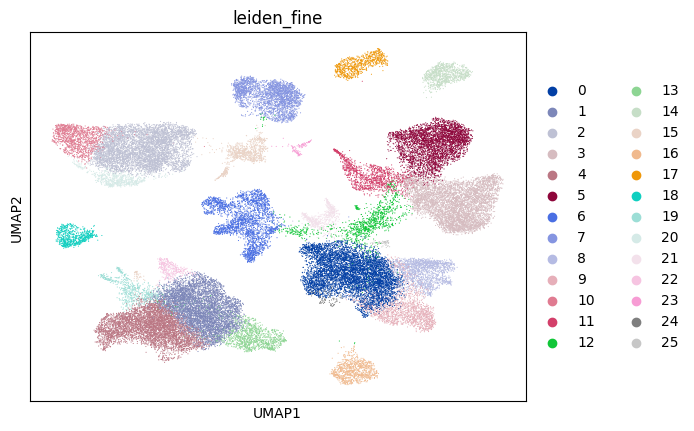

In [65]:
sc.pl.umap(adata, color = 'leiden_fine')

It looks like the maximum number of clusters that can be determined by this dataset is 26, which is a far cry from the previously reported 41 cell type clusters. This could be due to the fact that this is a subsample of the original data. This instance serves as a perfect display of why researchers are concerned with creating large atlases of scRNA-seq data. When there are many more cells to analyze, then there is much more resolution in parsing granular yet discrete cell types/states from one another. 

Another reason for this discrepancy most likely has to do with the fact that no "iterative clustering" was done. Put simply, iterative clustering is when the results from initial clustering are evaluated and refined through multiple rounds of the clustering algorithm. In the context of our scRNA-seq data, let's say we have a cluster that corresponds to Alveolar Epithelial Cells but we want to delineate Alveolar Type 1 cells from Alvoelar Type 2. We would take that cluster(i.e. Alveolar epithelial cells), split it off from the rest of the data and run the clustering algorithm on that subset of the data to delineate the cell types from one another.

In [66]:
# notice the added leiden annotations in adata.obs
adata

AnnData object with n_obs × n_vars = 49656 × 31332
    obs: 'group', 'donor', 'treatment', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'leiden_intermediate', 'leiden_main', 'leiden_fine'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'pca', 'neighbors', 'umap', 'leiden_intermediate', 'leiden_intermediate_colors', 'group_colors', 'leiden_main', 'leiden_main_colors', 'leiden_fine', 'leiden_fine_colors'
    obsm: 'X_scVI', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [69]:
# adata.write('..\Practice_2\data_2\GSE171524_clustered.h5ad')

## End of Practice 1

---